In [ ]:
#################
# Feb 2026 (last version)
#
# Made for GEOF232/337 (University of Bergen)
#
# Author: Koen van der Heijden, koen.heijden@uib.no

# Read RBR data files: read the processed RBR files into GFPy and make some plots

By now, you should have processed the CTD data and saved it into a .npy file. Now you can read this file with GFPy and make maps, plots, etc.

You can find examples on plotting with GFPy in ```GEOF232_V24_GFPy_MetOceanExamples.ipynb```

In [13]:
import os
import numpy as np
import GFPy.Ocean as oc

import matplotlib.pyplot as plt
import matplotlib as mpl

### 1. Read the processed .npy file (```CTD_205914_20240311_1533.npy```) into GFPy.Ocean 

### 2. Plot map of stations

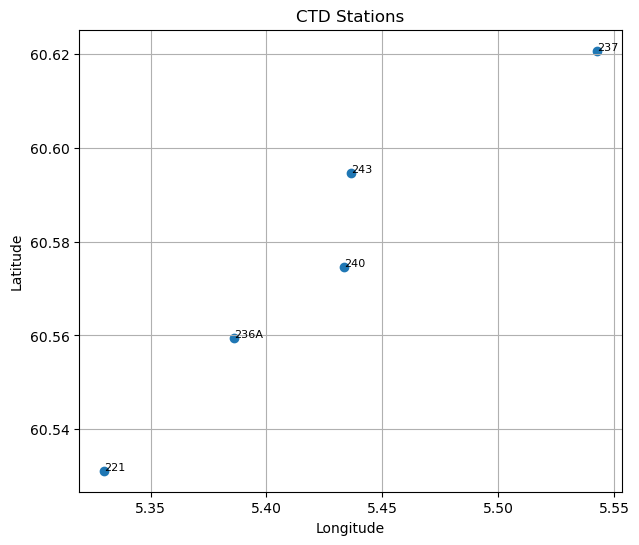

In [14]:
stations = get_station_ids(CTD_GFPy)

lats, lons, ids_ok = [], [], []
for sid in stations:
    st = get_station(CTD_GFPy, sid)
    lat, lon, z, t, s, o, _ = extract_basic_vars(st)
    if np.isfinite(lat) and np.isfinite(lon):
        lats.append(float(lat))
        lons.append(float(lon))
        ids_ok.append(sid)

lats = np.array(lats); lons = np.array(lons)

plt.figure(figsize=(7,6))
plt.scatter(lons, lats)
for lon, lat, sid in zip(lons, lats, ids_ok):
    plt.text(lon, lat, str(sid), fontsize=8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("CTD Stations")
plt.grid(True)
plt.show()


### 3. Plot temperature, salinity and dissolved oxygen profiles for station 221


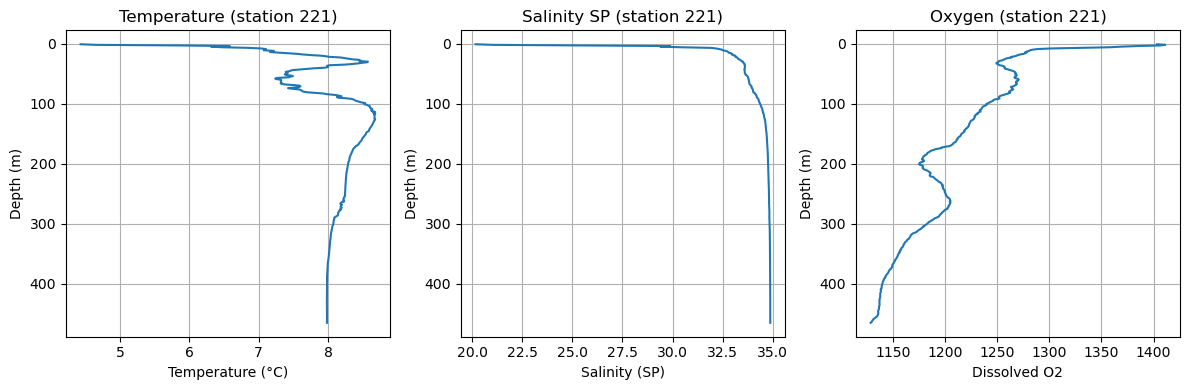

Keys in this station: ['LAT', 'LON', 'z', 'BottomDepth', 'p', 'C', 'SP', 'T', 'Sigma', 'OX raw', 'OX raw unit', 'Note', 'SA', 'CT', 'SIGTH', 'st']


In [17]:
station_id = 221  # 如果你数据里没有221，就换成 237 或 print(sorted(CTD_GFPy.keys())) 里存在的

# 如果 CTD_GFPy 是 np.ndarray 包了 dict，需要先 .item()
if isinstance(CTD_GFPy, np.ndarray) and CTD_GFPy.dtype == object:
    CTD = CTD_GFPy.item()
else:
    CTD = CTD_GFPy

if station_id not in CTD:
    raise KeyError(f"Station {station_id} not found. Available stations (first 20): {sorted(CTD.keys())[:20]}")

st = CTD[station_id]

z = np.asarray(st["z"], dtype=float)
T = np.asarray(st["T"], dtype=float)
SP = np.asarray(st["SP"], dtype=float)

# oxygen：你目前识别不到（o=None），先尝试几个常见名字；找不到就 None
o2_key = None
for k in ["O2", "o2", "Oxygen", "oxygen", "DO", "dox", "doxy", "Dissolved Oxygen", "O2 (umol/l)", "OX raw"]:
    if k in st:
        o2_key = k
        break
O2 = np.asarray(st[o2_key], dtype=float) if o2_key is not None else None

def clean_sort(z, x):
    ok = np.isfinite(z) & np.isfinite(x)
    zz, xx = z[ok], x[ok]
    idx = np.argsort(zz)
    return zz[idx], xx[idx]

zT, T = clean_sort(z, T)
zS, SP = clean_sort(z, SP)

plt.figure(figsize=(12,4))

# Temperature
plt.subplot(1,3,1)
plt.plot(T, zT)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title(f"Temperature (station {station_id})")
plt.grid(True)

# Salinity (SP)
plt.subplot(1,3,2)
plt.plot(SP, zS)
plt.gca().invert_yaxis()
plt.xlabel("Salinity (SP)")
plt.ylabel("Depth (m)")
plt.title(f"Salinity SP (station {station_id})")
plt.grid(True)

# Oxygen
plt.subplot(1,3,3)
if O2 is None:
    plt.text(0.5, 0.5, "Dissolved oxygen not\navailable in this .npy",
             ha="center", va="center")
    plt.axis("off")
    plt.title(f"Oxygen (station {station_id})")
else:
    zO, O2 = clean_sort(z, O2)
    plt.plot(O2, zO)
    plt.gca().invert_yaxis()
    plt.xlabel("Dissolved O2")
    plt.ylabel("Depth (m)")
    plt.title(f"Oxygen (station {station_id})")
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Keys in this station:", list(st.keys()))

### 4. Plot temperature, salinity and dissolved oxygen profiles for all stations


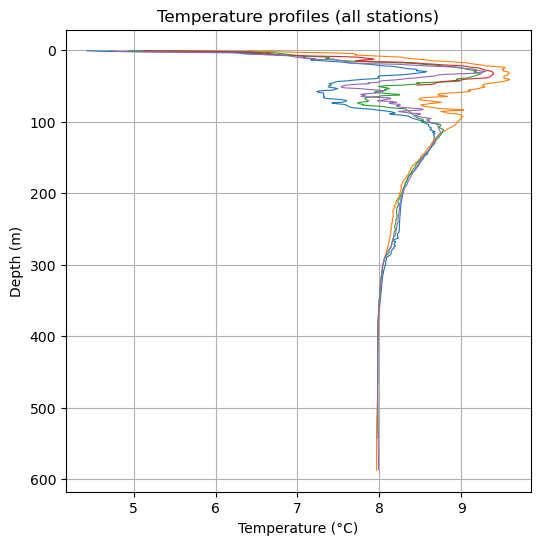

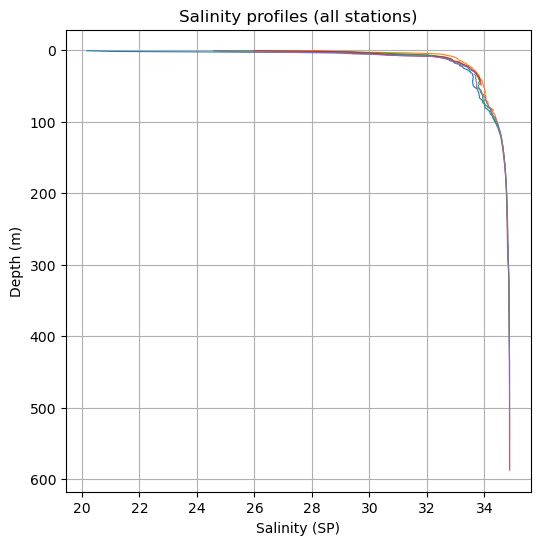

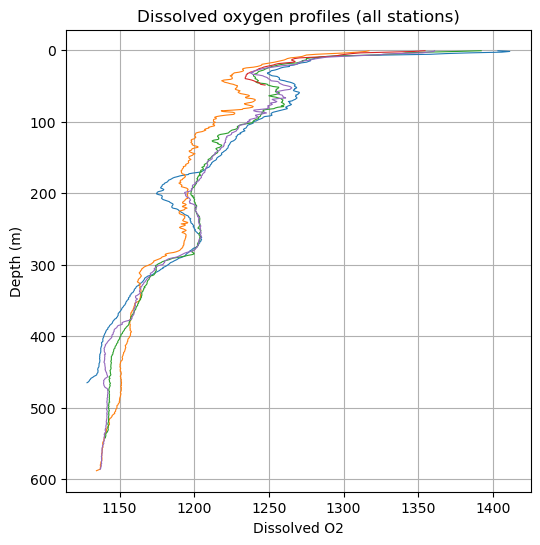

In [20]:
CTD = CTD_GFPy.item() if isinstance(CTD_GFPy, np.ndarray) else CTD_GFPy

# --- station list: handle mixed int/str keys ---
int_ids = sorted([k for k in CTD.keys() if isinstance(k, int)])
str_ids = sorted([k for k in CTD.keys() if isinstance(k, str)])
stations = int_ids + str_ids

def clean_sort(z, x):
    z = np.asarray(z, float)
    x = np.asarray(x, float)
    ok = np.isfinite(z) & np.isfinite(x)
    z2, x2 = z[ok], x[ok]
    if z2.size == 0:
        return z2, x2
    idx = np.argsort(z2)
    return z2[idx], x2[idx]

def find_o2_key(st):
    # 你们数据里氧可能压根没有；这里尽量找常见命名
    candidates = [
        "O2", "o2", "Oxygen", "oxygen", "DO", "do", "dox", "doxy",
        "Dissolved Oxygen", "O2 (umol/l)", "O2_umolL", "OX raw"
    ]
    for k in candidates:
        if k in st:
            return k
    return None

# ---------- Temperature profiles ----------
plt.figure(figsize=(6,6))
for sid in stations:
    st = CTD[sid]
    if "z" in st and "T" in st:
        z, T = clean_sort(st["z"], st["T"])
        if z.size:
            plt.plot(T, z, linewidth=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title("Temperature profiles (all stations)")
plt.grid(True)
plt.show()

# ---------- Salinity (SP) profiles ----------
plt.figure(figsize=(6,6))
for sid in stations:
    st = CTD[sid]
    if "z" in st and "SP" in st:
        z, SP = clean_sort(st["z"], st["SP"])
        if z.size:
            plt.plot(SP, z, linewidth=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Salinity (SP)")
plt.ylabel("Depth (m)")
plt.title("Salinity profiles (all stations)")
plt.grid(True)
plt.show()

# ---------- Dissolved oxygen profiles ----------
plt.figure(figsize=(6,6))
plotted = 0
for sid in stations:
    st = CTD[sid]
    if "z" not in st:
        continue
    o2_key = find_o2_key(st)
    if o2_key is None:
        continue
    z, O2 = clean_sort(st["z"], st[o2_key])
    if z.size:
        plt.plot(O2, z, linewidth=0.8)
        plotted += 1

if plotted == 0:
    plt.text(0.5, 0.5, "No dissolved oxygen variable found in this dataset",
             ha="center", va="center")
    plt.axis("off")
else:
    plt.gca().invert_yaxis()
    plt.xlabel("Dissolved O2")
    plt.ylabel("Depth (m)")
    plt.grid(True)

plt.title("Dissolved oxygen profiles (all stations)")
plt.show()

### 5. Plot T, S diagram for all stations


Make two diagrams: one colored by station, and one colored by depth

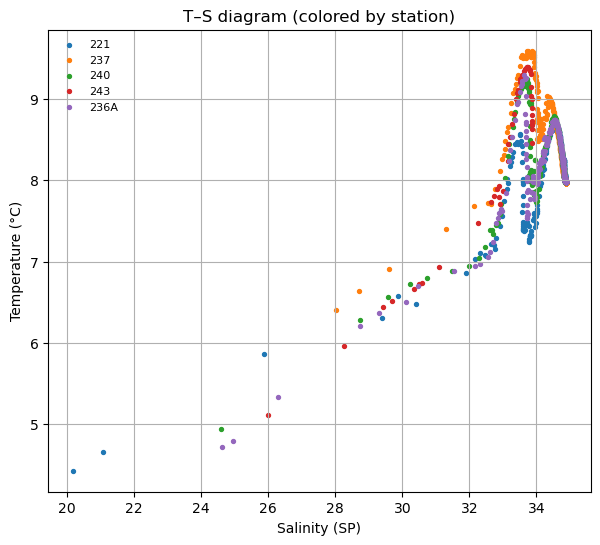

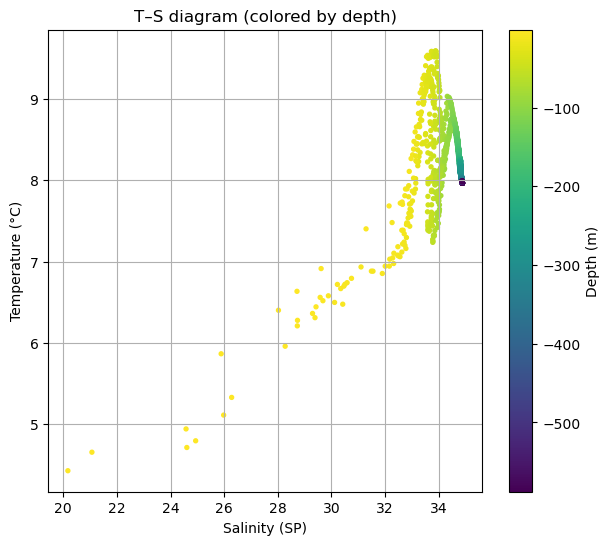

In [22]:
CTD = CTD_GFPy.item() if isinstance(CTD_GFPy, np.ndarray) else CTD_GFPy

# 处理混合站号 key：int + str
int_ids = sorted([k for k in CTD.keys() if isinstance(k, int)])
str_ids = sorted([k for k in CTD.keys() if isinstance(k, str)])
stations = int_ids + str_ids

def valid_TS(st):
    if ("T" not in st) or ("SP" not in st):
        return None, None, None
    T = np.asarray(st["T"], float)
    S = np.asarray(st["SP"], float)
    z = np.asarray(st["z"], float) if "z" in st else np.full_like(T, np.nan, dtype=float)

    ok = np.isfinite(T) & np.isfinite(S) & np.isfinite(z)
    if ok.sum() == 0:
        return None, None, None
    return T[ok], S[ok], z[ok]

# -------------------------
# 5a) T–S colored by station
# -------------------------
plt.figure(figsize=(7,6))
nplotted = 0
for sid in stations:
    st = CTD[sid]
    T, S, z = valid_TS(st)
    if T is None:
        continue
    plt.scatter(S, T, s=8, label=str(sid))
    nplotted += 1

plt.xlabel("Salinity (SP)")
plt.ylabel("Temperature (°C)")
plt.title("T–S diagram (colored by station)")
plt.grid(True)

# 站很多的话 legend 会很挤，这里做个相对温和的处理
if nplotted <= 12:
    plt.legend(fontsize=8, frameon=False)
else:
    plt.legend(fontsize=7, ncol=2, frameon=False)

plt.show()

# -------------------------
# 5b) T–S colored by depth
# -------------------------
T_all, S_all, z_all = [], [], []
for sid in stations:
    st = CTD[sid]
    T, S, z = valid_TS(st)
    if T is None:
        continue
    T_all.append(T); S_all.append(S); z_all.append(z)

T_all = np.concatenate(T_all) if T_all else np.array([])
S_all = np.concatenate(S_all) if S_all else np.array([])
z_all = np.concatenate(z_all) if z_all else np.array([])

plt.figure(figsize=(7,6))
sc = plt.scatter(S_all, T_all, c=-z_all, s=8)
plt.xlabel("Salinity (SP)")
plt.ylabel("Temperature (°C)")
plt.title("T–S diagram (colored by depth)")
plt.grid(True)
cb = plt.colorbar(sc)
cb.set_label("Depth (m)")
plt.show()